In [ ]:
!pip install scikit-learn


In [ ]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00


# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import itertools

# Load data from CSV
hpg_data = pd.read_csv('/content/HPG.csv', parse_dates=['Date'], index_col='Date')
mwg_data = pd.read_csv('/content/MWG.csv', parse_dates=['Date'], index_col='Date')

# Convert the 'Price' column to numeric, which will handle commas
hpg_data['Price'] = pd.to_numeric(hpg_data['Price'].str.replace(',', ''), errors='coerce')
mwg_data['Price'] = pd.to_numeric(mwg_data['Price'].str.replace(',', ''), errors='coerce')

# Ensure the DatetimeIndex is sorted
hpg_data = hpg_data.sort_index().asfreq('B')
mwg_data = mwg_data.sort_index().asfreq('B')

# Handle missing values
hpg_data = hpg_data.ffill().bfill()
mwg_data = mwg_data.ffill().bfill()

print("HPG Data Head:")
print(hpg_data.head())
print("MWG Data Head:")
print(mwg_data.head())

HPG Data Head:
              Price      Open      High       Low    Vol. Change %
Date                                                              
2018-01-02  11991.0  11,789.9  12,003.6  11,676.8  15.73M    1.81%
2018-01-03  11965.9  12,066.4  12,192.1  11,890.5  18.51M   -0.21%
2018-01-04  12116.7  12,016.2  12,167.0  11,965.9  17.79M    1.26%
2018-01-05  12066.4  12,091.6  12,179.6  11,978.4  14.03M   -0.42%
2018-01-08  12443.5  11,991.0  12,443.5  11,940.7  14.19M    3.13%
MWG Data Head:
              Price    Open    High     Low   Vol. Change %
Date                                                       
2018-01-02  31276.0  31,039  31,394  31,039  2.27M    0.76%
2018-01-03  31892.0  31,323  32,034  31,276  4.53M    1.97%
2018-01-04  31963.0  31,773  32,081  31,750  2.71M    0.22%
2018-01-05  31608.0  31,987  31,987  31,465  2.93M   -1.11%
2018-01-08  31110.0  31,394  31,513  31,039  3.01M   -1.58%


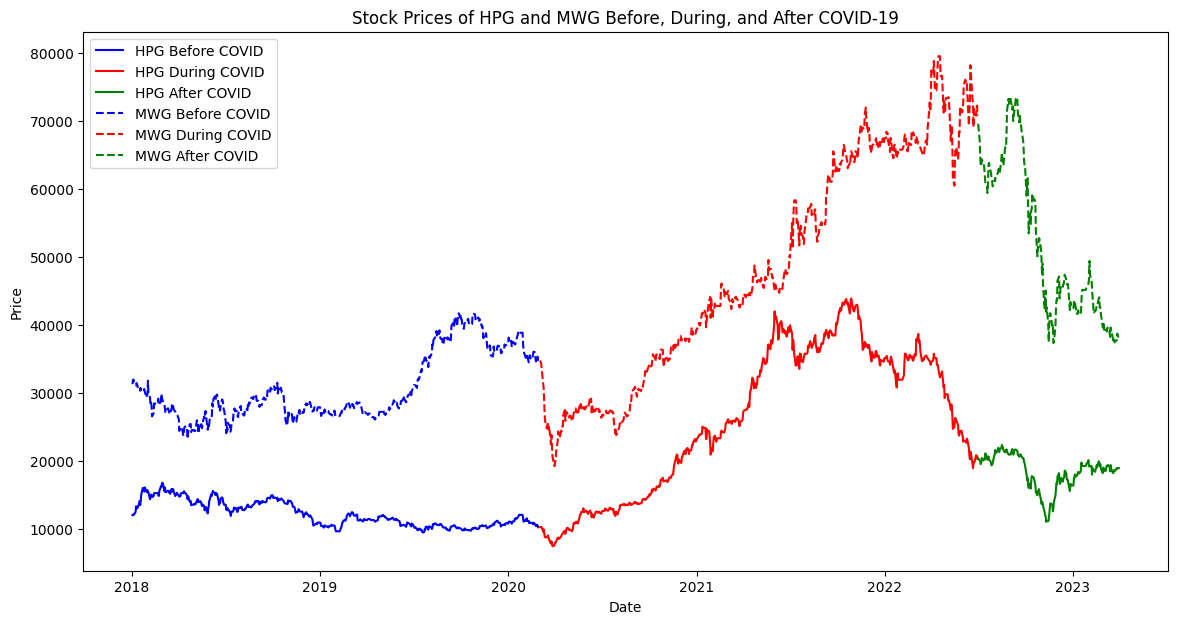

In [ ]:
# Define date ranges
before_covid_end = '2020-03-01'
during_covid_end = '2022-06-30'
before_covid = hpg_data.index < before_covid_end
during_covid = (hpg_data.index >= before_covid_end) & (hpg_data.index <= during_covid_end)
after_covid = hpg_data.index > during_covid_end

# Plot prices with different colors for different periods
plt.figure(figsize=(14, 7))

# HPG Data
plt.plot(hpg_data.index[before_covid], hpg_data['Price'][before_covid], label='HPG Before COVID', color='blue', linestyle='-')
plt.plot(hpg_data.index[during_covid], hpg_data['Price'][during_covid], label='HPG During COVID', color='red', linestyle='-')
plt.plot(hpg_data.index[after_covid], hpg_data['Price'][after_covid], label='HPG After COVID', color='green', linestyle='-')

# MWG Data
plt.plot(mwg_data.index[before_covid], mwg_data['Price'][before_covid], label='MWG Before COVID', color='blue', linestyle='--')
plt.plot(mwg_data.index[during_covid], mwg_data['Price'][during_covid], label='MWG During COVID', color='red', linestyle='--')
plt.plot(mwg_data.index[after_covid], mwg_data['Price'][after_covid], label='MWG After COVID', color='green', linestyle='--')

plt.title('Stock Prices of HPG and MWG Before, During, and After COVID-19')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

              Price
count   1369.000000
mean   19236.517677
std     9734.458137
min     7411.800000
25%    11649.100000
50%    15007.600000
75%    23874.000000
max    43895.800000
              Price
count   1369.000000
mean   41615.499635
std    15387.578223
min    19198.000000
25%    28100.000000
50%    37612.000000
75%    51506.000000
max    79582.000000


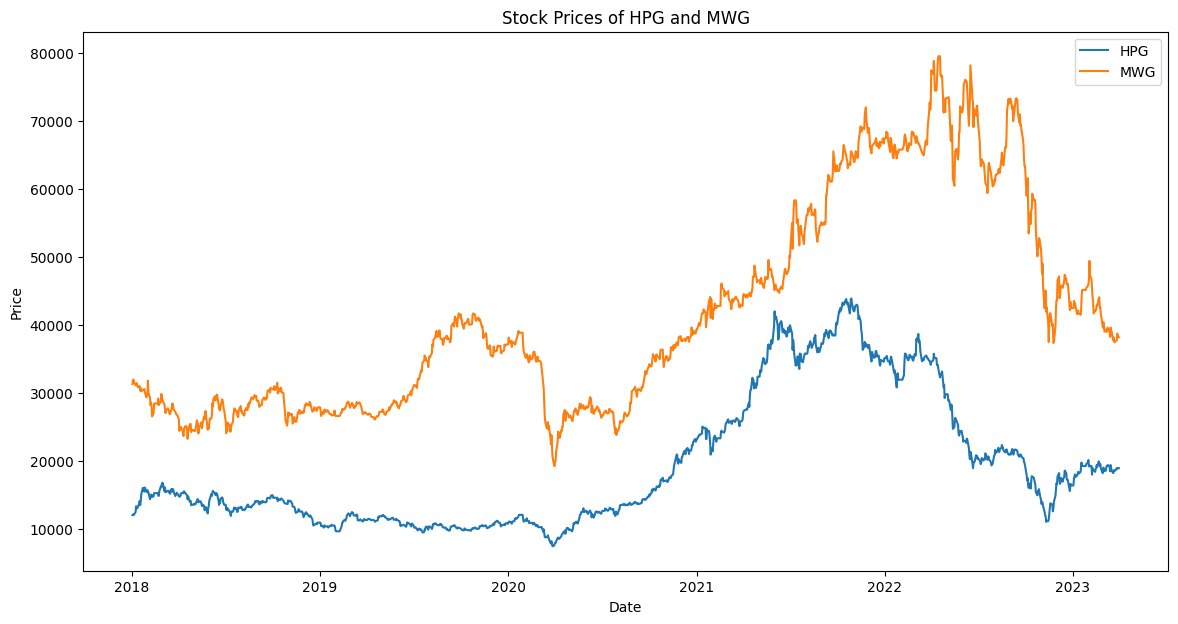

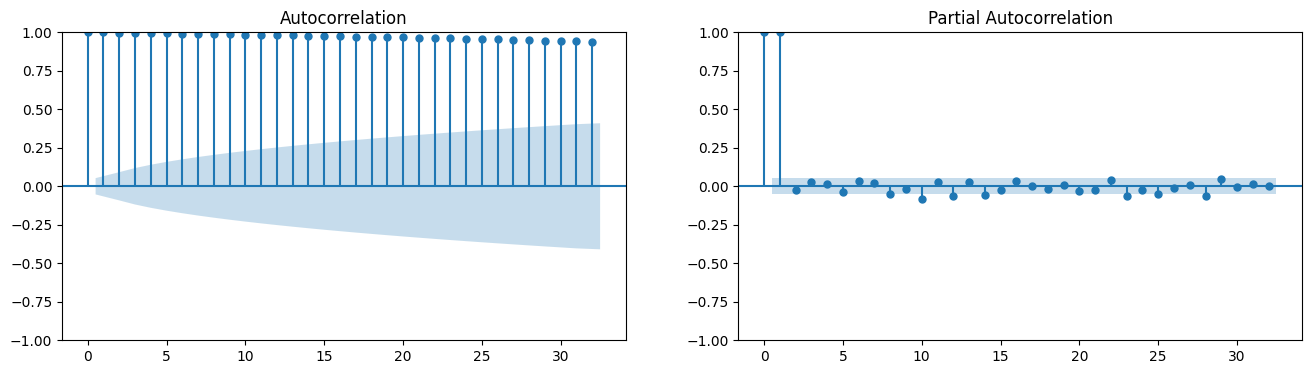

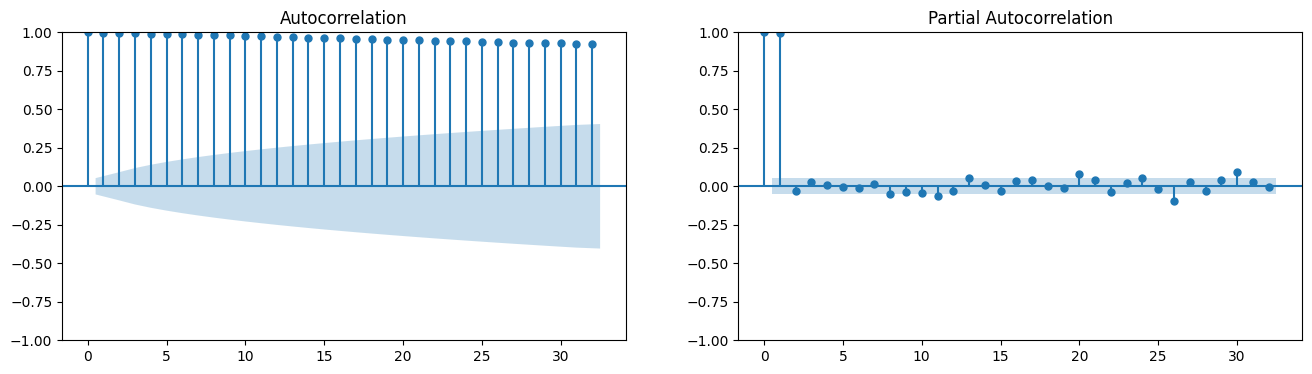

In [ ]:
# Basic descriptive statistics
print(hpg_data.describe())
print(mwg_data.describe())

# Plotting stock prices
plt.figure(figsize=(14, 7))
plt.plot(hpg_data.index, hpg_data['Price'], label='HPG')
plt.plot(mwg_data.index, mwg_data['Price'], label='MWG')
plt.title('Stock Prices of HPG and MWG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting ACF and PACF for HPG
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(hpg_data['Price'], ax=axes[0])
plot_pacf(hpg_data['Price'], ax=axes[1])
plt.show()

# Plotting ACF and PACF for MWG
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(mwg_data['Price'], ax=axes[0])
plot_pacf(mwg_data['Price'], ax=axes[1])
plt.show()

HPG Seasonality and Trend Analysis:


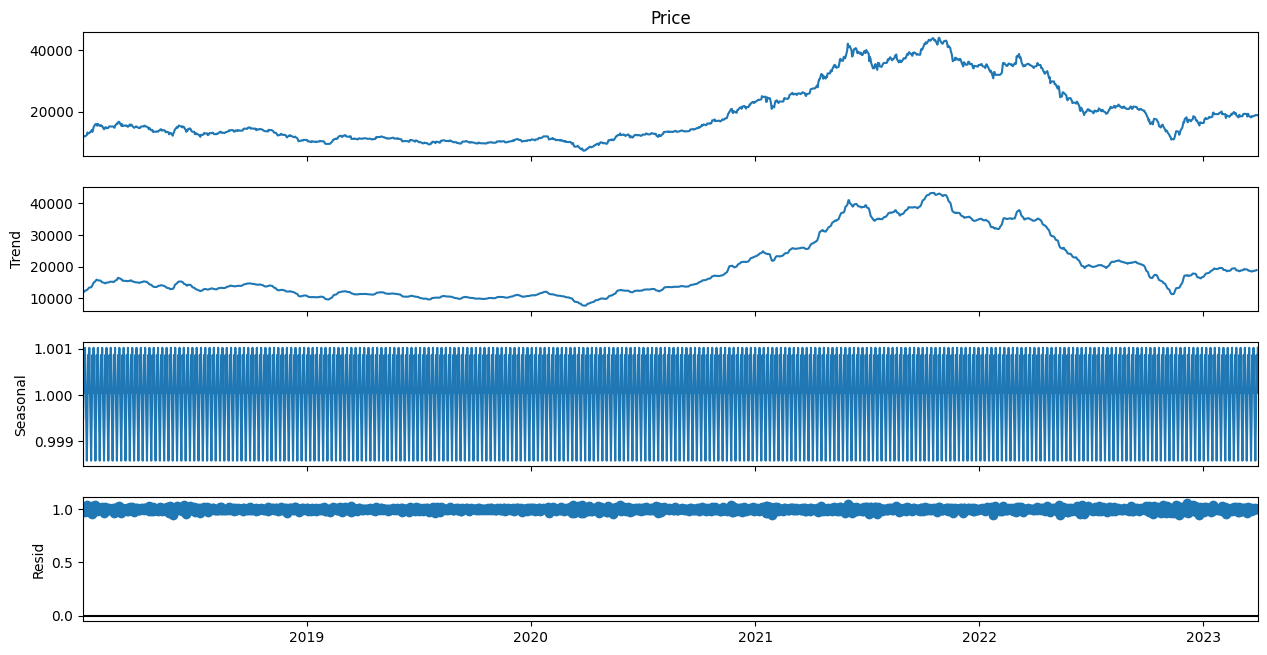

MWG Seasonality and Trend Analysis:


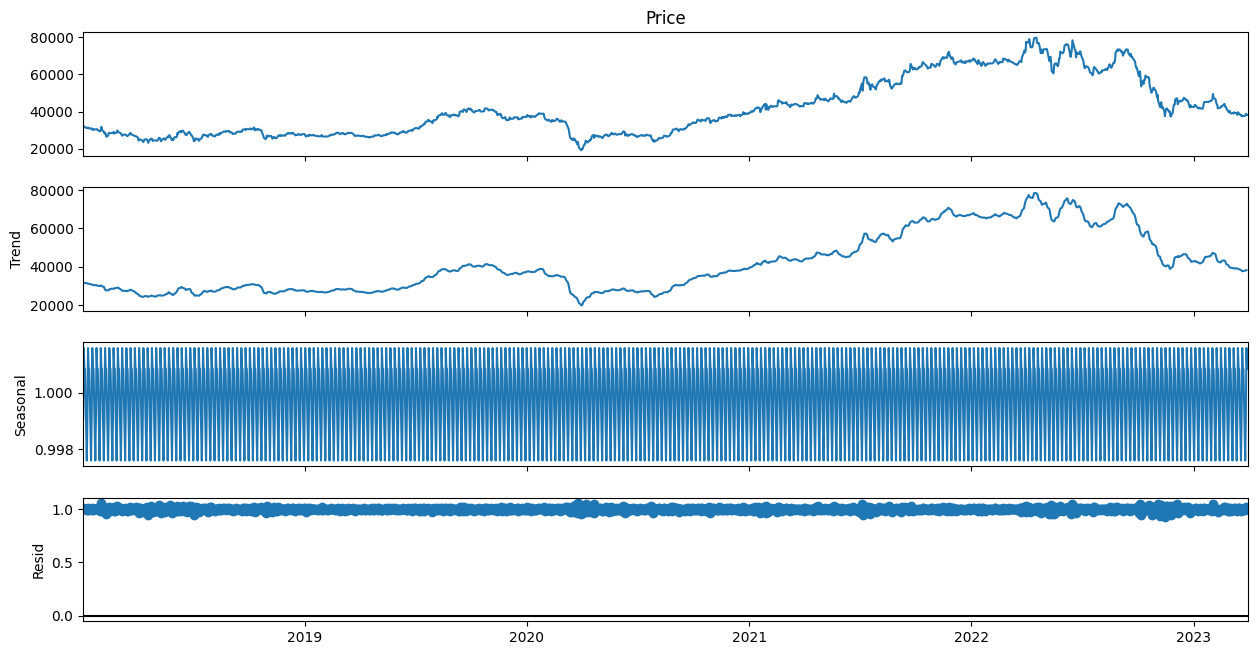

Distribution of HPG Prices:


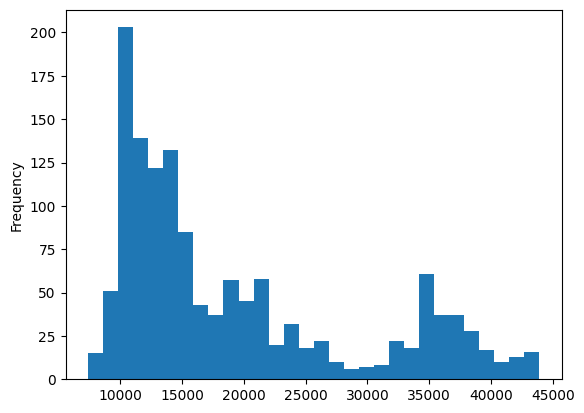

Distribution of MWG Prices:


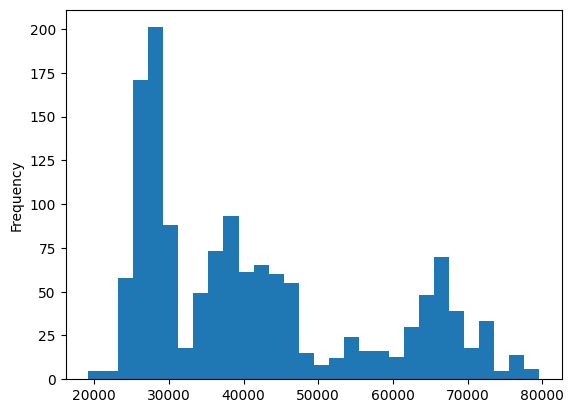

Correlation between HPG and MWG prices: 0.7633424220320922
HPG Lag Plot:


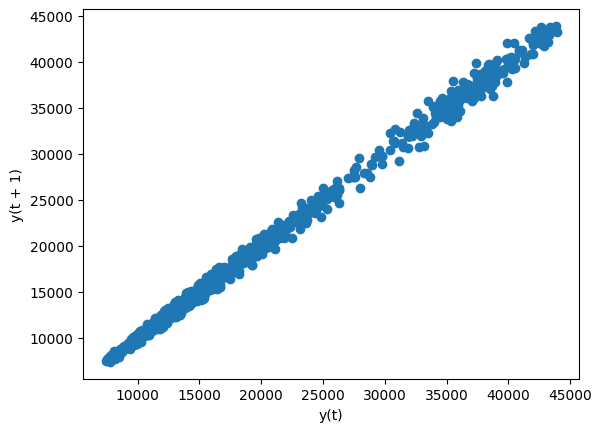

MWG Lag Plot:


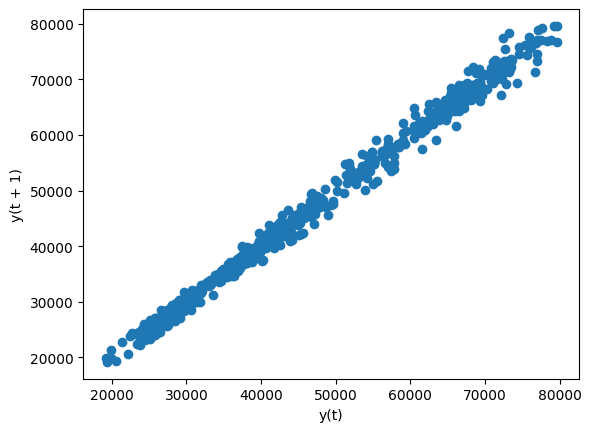

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot

# Seasonality and Trend Analysis
decomposition_hpg = seasonal_decompose(hpg_data['Price'], model='multiplicative')
decomposition_mwg = seasonal_decompose(mwg_data['Price'], model='multiplicative')

print("HPG Seasonality and Trend Analysis:")
fig = decomposition_hpg.plot()
fig.set_size_inches(14,7)
plt.show()

print("MWG Seasonality and Trend Analysis:")
fig = decomposition_mwg.plot()
fig.set_size_inches(14, 7)
plt.show()

# Distribution of Prices
print("Distribution of HPG Prices:")
hpg_data['Price'].plot(kind='hist', bins=30)
plt.show()

print("Distribution of MWG Prices:")
mwg_data['Price'].plot(kind='hist', bins=30)
plt.show()

# Correlation Analysis
correlation = hpg_data['Price'].corr(mwg_data['Price'])
print(f'Correlation between HPG and MWG prices: {correlation}')

# Lag Plot
print("HPG Lag Plot:")
lag_plot(hpg_data['Price'])
plt.show()

print("MWG Lag Plot:")
lag_plot(mwg_data['Price'])
plt.show()


#ARIMA

HPG Stationarity Check Before Differencing
ADF Statistic: -1.2246363127835178
p-value: 0.6629090340959353
Weak evidence against the null hypothesis, data is non-stationary.

MWG Stationarity Check Before Differencing
ADF Statistic: -1.2055142793546043
p-value: 0.6712191211372742
Weak evidence against the null hypothesis, data is non-stationary.

HPG Stationarity Check After Differencing
ADF Statistic: -7.818872627008357
p-value: 6.753835079507289e-12
Strong evidence against the null hypothesis, data is stationary.

MWG Stationarity Check After Differencing
ADF Statistic: -7.34265039945755
p-value: 1.0552761958537223e-10
Strong evidence against the null hypothesis, data is stationary.


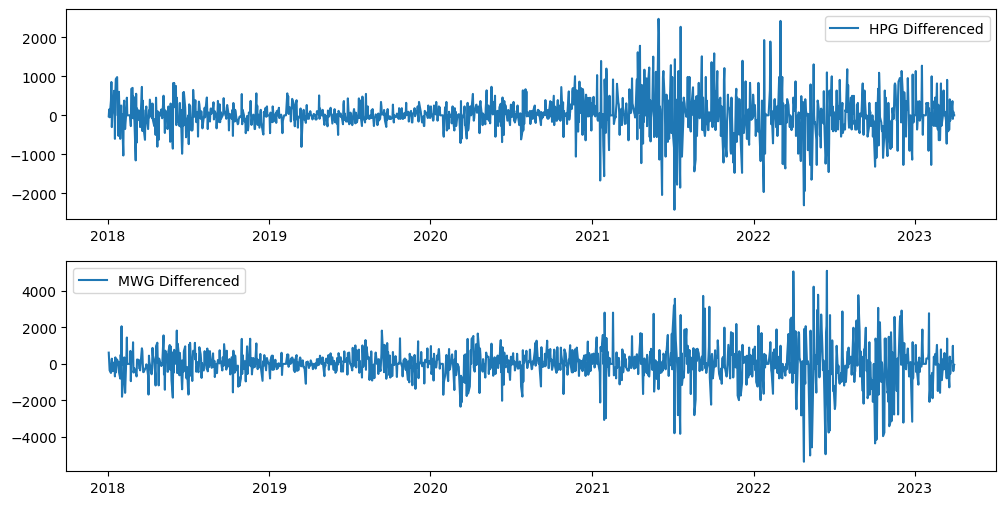

In [ ]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, data is stationary.")
    else:
        print("Weak evidence against the null hypothesis, data is non-stationary.")

# Function to apply differencing to make data stationary
def make_stationary(data):
    data_diff = data.diff().dropna()
    return data_diff

# Perform ADF test before differencing
print("HPG Stationarity Check Before Differencing")
adf_test(hpg_data['Price'])
print("\nMWG Stationarity Check Before Differencing")
adf_test(mwg_data['Price'])

# Apply differencing if necessary
if adfuller(hpg_data['Price'])[1] > 0.05:
    hpg_data_diff = make_stationary(hpg_data['Price'])
else:
    hpg_data_diff = hpg_data['Price']

if adfuller(mwg_data['Price'])[1] > 0.05:
    mwg_data_diff = make_stationary(mwg_data['Price'])
else:
    mwg_data_diff = mwg_data['Price']

# Perform ADF test after differencing
print("\nHPG Stationarity Check After Differencing")
adf_test(hpg_data_diff)
print("\nMWG Stationarity Check After Differencing")
adf_test(mwg_data_diff)

# Plot differenced data to check stationarity visually
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(hpg_data_diff, label='HPG Differenced')
plt.legend(loc='best')
plt.subplot(212)
plt.plot(mwg_data_diff, label='MWG Differenced')
plt.legend(loc='best')
plt.show()

In [ ]:
# Define the ARIMA parameters
order = (2, 1, 0)

# Function to perform walk-forward validation
def walk_forward_arima(train, test, order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return predictions

# Perform walk-forward validation for HPG and MWG
pred_hpg_arima = walk_forward_arima(train_hpg_arima, test_hpg_arima, order)
pred_mwg_arima = walk_forward_arima(train_mwg_arima, test_mwg_arima, order)

# Convert predictions to Pandas Series for easier plotting and evaluation
pred_hpg_arima = pd.Series(pred_hpg_arima, index=test_hpg_arima.index)
pred_mwg_arima = pd.Series(pred_mwg_arima, index=test_mwg_arima.index)

# Transform predictions back to the original scale if differenced
if adfuller(hpg_data['Price'])[1] > 0.05:
    last_train_hpg_price = hpg_data['Price'].loc[train_hpg_arima.index[-1]]
    pred_hpg_arima = last_train_hpg_price + pred_hpg_arima.cumsum()

if adfuller(mwg_data['Price'])[1] > 0.05:
    last_train_mwg_price = mwg_data['Price'].loc[train_mwg_arima.index[-1]]
    pred_mwg_arima = last_train_mwg_price + pred_mwg_arima.cumsum()

# Function to align actual and predicted values and calculate evaluation metrics
def evaluate_predictions(actual, pred, stock_name):
    actual, pred = actual.align(pred, join='inner')
    if len(actual) == 0 or len(pred) == 0:
        print(f"Error: One of the series is empty after alignment for {stock_name}. Please check the data.")
    else:
        r2 = r2_score(actual, pred)
        mape = mean_absolute_percentage_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        print(f'ARIMA {stock_name} - R^2: {r2}, MAPE: {mape}, RMSE: {rmse}')

# Evaluate predictions for HPG and MWG
evaluate_predictions(hpg_data['Price']['2022-03-01':], pred_hpg_arima, 'HPG')
evaluate_predictions(mwg_data['Price']['2022-03-01':], pred_mwg_arima, 'MWG')

ARIMA HPG - R^2: 0.9667612653254817, MAPE: 0.048179203419725765, RMSE: 1157.3233604621287
ARIMA MWG - R^2: 0.9745122054307798, MAPE: 0.028295904157047934, RMSE: 2113.6345370844106


#LSTM

In [ ]:
# Feature Engineering for LSTM
train_hpg_lstm = hpg_data[:'2022-1-10']
test_hpg_lstm = hpg_data['2022-1-11':]

train_mwg_lstm = mwg_data[:'2022-1-10']
test_mwg_lstm = mwg_data['2022-1-11':]

# Add moving average feature
train_hpg_lstm['MA7'] = train_hpg_lstm['Price'].rolling(window=7).mean()
test_hpg_lstm['MA7'] = test_hpg_lstm['Price'].rolling(window=7).mean()

train_mwg_lstm['MA7'] = train_mwg_lstm['Price'].rolling(window=7).mean()
test_mwg_lstm['MA7'] = test_mwg_lstm['Price'].rolling(window=7).mean()

# Fill missing values after adding moving averages
train_hpg_lstm = train_hpg_lstm.ffill().bfill()
test_hpg_lstm = test_hpg_lstm.ffill().bfill()

train_mwg_lstm = train_mwg_lstm.ffill().bfill()
test_mwg_lstm = test_mwg_lstm.ffill().bfill()

# Debugging: Print the data after feature engineering
print("Train HPG LSTM Data Head:")
print(train_hpg_lstm.head())
print("Test HPG LSTM Data Head:")
print(test_hpg_lstm.head())
print("Train MWG LSTM Data Head:")
print(train_mwg_lstm.head())
print("Test MWG LSTM Data Head:")
print(test_mwg_lstm.head())

# Scaling the data for LSTM
scaler_hpg = MinMaxScaler()
scaler_mwg = MinMaxScaler()

train_hpg_scaled = scaler_hpg.fit_transform(train_hpg_lstm[['Price', 'MA7']])
test_hpg_scaled = scaler_hpg.transform(test_hpg_lstm[['Price', 'MA7']])

train_mwg_scaled = scaler_mwg.fit_transform(train_mwg_lstm[['Price', 'MA7']])
test_mwg_scaled = scaler_mwg.transform(test_mwg_lstm[['Price', 'MA7']])

# Create sequences for LSTM
seq_length = 30
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length, 0]  # predict the 'Price' column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train_hpg, y_train_hpg = create_sequences(train_hpg_scaled, seq_length)
X_test_hpg, y_test_hpg = create_sequences(test_hpg_scaled, seq_length)

X_train_mwg, y_train_mwg = create_sequences(train_mwg_scaled, seq_length)
X_test_mwg, y_test_mwg = create_sequences(test_mwg_scaled, seq_length)

Train HPG LSTM Data Head:
              Price      Open      High       Low    Vol. Change %  \
Date                                                                 
2018-01-02  11991.0  11,789.9  12,003.6  11,676.8  15.73M    1.81%   
2018-01-03  11965.9  12,066.4  12,192.1  11,890.5  18.51M   -0.21%   
2018-01-04  12116.7  12,016.2  12,167.0  11,965.9  17.79M    1.26%   
2018-01-05  12066.4  12,091.6  12,179.6  11,978.4  14.03M   -0.42%   
2018-01-08  12443.5  11,991.0  12,443.5  11,940.7  14.19M    3.13%   

                     MA7  
Date                      
2018-01-02  12411.171429  
2018-01-03  12411.171429  
2018-01-04  12411.171429  
2018-01-05  12411.171429  
2018-01-08  12411.171429  
Test HPG LSTM Data Head:
              Price      Open      High       Low    Vol. Change %  \
Date                                                                 
2022-01-11  34132.8  34,851.7  34,851.7  34,132.8  16.59M   -1.20%   
2022-01-12  34965.3  34,208.4  35,003.1  34,170.6  19.09M  

<ipython-input-27-e232bd68a7c1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_hpg_lstm['MA7'] = train_hpg_lstm['Price'].rolling(window=7).mean()
<ipython-input-27-e232bd68a7c1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_hpg_lstm['MA7'] = test_hpg_lstm['Price'].rolling(window=7).mean()
<ipython-input-27-e232bd68a7c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train LSTM model for HPG
lstm_model_hpg = build_lstm_model((X_train_hpg.shape[1], X_train_hpg.shape[2]))
history_hpg = lstm_model_hpg.fit(X_train_hpg, y_train_hpg, epochs=100, batch_size=32, validation_split=0.2)

# Train LSTM model for MWG
lstm_model_mwg = build_lstm_model((X_train_mwg.shape[1], X_train_mwg.shape[2]))
history_mwg = lstm_model_mwg.fit(X_train_mwg, y_train_mwg, epochs=100, batch_size=32, validation_split=0.2)

# Make predictions for LSTM
pred_hpg_lstm = lstm_model_hpg.predict(X_test_hpg)
pred_mwg_lstm = lstm_model_mwg.predict(X_test_mwg)

# Rescale predictions for LSTM
pred_hpg_lstm = scaler_hpg.inverse_transform(np.concatenate((pred_hpg_lstm, np.zeros((pred_hpg_lstm.shape[0], 1))), axis=1))[:, 0]
pred_mwg_lstm = scaler_mwg.inverse_transform(np.concatenate((pred_mwg_lstm, np.zeros((pred_mwg_lstm.shape[0], 1))), axis=1))[:, 0]

# Calculate evaluation metrics for LSTM
r2_hpg_lstm = r2_score(test_hpg_lstm['Price'][seq_length:], pred_hpg_lstm)
mape_hpg_lstm = mean_absolute_percentage_error(test_hpg_lstm['Price'][seq_length:], pred_hpg_lstm)
rmse_hpg_lstm = np.sqrt(mean_squared_error(test_hpg_lstm['Price'][seq_length:], pred_hpg_lstm))

r2_mwg_lstm = r2_score(test_mwg_lstm['Price'][seq_length:], pred_mwg_lstm)
mape_mwg_lstm = mean_absolute_percentage_error(test_mwg_lstm['Price'][seq_length:], pred_mwg_lstm)
rmse_mwg_lstm = np.sqrt(mean_squared_error(test_mwg_lstm['Price'][seq_length:], pred_mwg_lstm))

print(f'LSTM HPG - R^2: {r2_hpg_lstm}, MAPE: {mape_hpg_lstm}, RMSE: {rmse_hpg_lstm}')
print(f'LSTM MWG - R^2: {r2_mwg_lstm}, MAPE: {mape_mwg_lstm}, RMSE: {rmse_mwg_lstm}')

Epoch 1/100
26/26 [==============================] - 8s 92ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 2/100
26/26 [==============================] - 2s 67ms/step - loss: 7.1150e-04 - val_loss: 0.0030
Epoch 3/100
26/26 [==============================] - 2s 93ms/step - loss: 5.7499e-04 - val_loss: 0.0025
Epoch 4/100
26/26 [==============================] - 2s 66ms/step - loss: 5.4977e-04 - val_loss: 0.0032
Epoch 5/100
26/26 [==============================] - 1s 56ms/step - loss: 4.8909e-04 - val_loss: 0.0022
Epoch 6/100
26/26 [==============================] - 1s 56ms/step - loss: 4.0885e-04 - val_loss: 0.0019
Epoch 7/100
26/26 [==============================] - 1s 56ms/step - loss: 5.3503e-04 - val_loss: 0.0020
Epoch 8/100
26/26 [==============================] - 1s 56ms/step - loss: 4.4903e-04 - val_loss: 0.0023
Epoch 9/100
26/26 [==============================] - 1s 55ms/step - loss: 3.8354e-04 - val_loss: 0.0017
Epoch 10/100
26/26 [==============================] - 1s 55ms/step -

# GRU

In [ ]:
from tensorflow.keras.layers import GRU

# Define GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train GRU model for HPG
gru_model_hpg = build_gru_model((X_train_hpg.shape[1], X_train_hpg.shape[2]))
history_hpg = gru_model_hpg.fit(X_train_hpg, y_train_hpg, epochs=50, batch_size=64, validation_split=0.2)

# Train GRU model for MWG
gru_model_mwg = build_gru_model((X_train_mwg.shape[1], X_train_mwg.shape[2]))
history_mwg = gru_model_mwg.fit(X_train_mwg, y_train_mwg, epochs=50, batch_size=64, validation_split=0.2)

# Make predictions for GRU
pred_hpg_gru = gru_model_hpg.predict(X_test_hpg)
pred_mwg_gru = gru_model_mwg.predict(X_test_mwg)

# Rescale predictions for GRU
pred_hpg_gru = scaler_hpg.inverse_transform(np.concatenate((pred_hpg_gru, np.zeros((pred_hpg_gru.shape[0], 1))), axis=1))[:, 0]
pred_mwg_gru = scaler_mwg.inverse_transform(np.concatenate((pred_mwg_gru, np.zeros((pred_mwg_gru.shape[0], 1))), axis=1))[:, 0]

# Calculate evaluation metrics for GRU
r2_hpg_gru = r2_score(test_hpg_lstm['Price'][seq_length:], pred_hpg_gru)
mape_hpg_gru = mean_absolute_percentage_error(test_hpg_lstm['Price'][seq_length:], pred_hpg_gru)
rmse_hpg_gru = np.sqrt(mean_squared_error(test_hpg_lstm['Price'][seq_length:], pred_hpg_gru))

r2_mwg_gru = r2_score(test_mwg_lstm['Price'][seq_length:], pred_mwg_gru)
mape_mwg_gru = mean_absolute_percentage_error(test_mwg_lstm['Price'][seq_length:], pred_mwg_gru)
rmse_mwg_gru = np.sqrt(mean_squared_error(test_mwg_lstm['Price'][seq_length:], pred_mwg_gru))

print(f'GRU HPG - R^2: {r2_hpg_gru}, MAPE: {mape_hpg_gru}, RMSE: {rmse_hpg_gru}')
print(f'GRU MWG - R^2: {r2_mwg_gru}, MAPE: {mape_mwg_gru}, RMSE: {rmse_mwg_gru}')

Epoch 1/50
13/13 [==============================] - 7s 163ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 2/50
13/13 [==============================] - 1s 94ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 3/50
13/13 [==============================] - 1s 94ms/step - loss: 6.6609e-04 - val_loss: 0.0031
Epoch 4/50
13/13 [==============================] - 1s 96ms/step - loss: 5.6490e-04 - val_loss: 0.0012
Epoch 5/50
13/13 [==============================] - 1s 99ms/step - loss: 4.6181e-04 - val_loss: 0.0013
Epoch 6/50
13/13 [==============================] - 2s 185ms/step - loss: 3.8285e-04 - val_loss: 0.0017
Epoch 7/50
13/13 [==============================] - 2s 161ms/step - loss: 4.5839e-04 - val_loss: 0.0014
Epoch 8/50
13/13 [==============================] - 1s 98ms/step - loss: 3.9866e-04 - val_loss: 0.0012
Epoch 9/50
13/13 [==============================] - 1s 92ms/step - loss: 3.2370e-04 - val_loss: 0.0010
Epoch 10/50
13/13 [==============================] - 1s 94ms/step - loss: 3.05

#Plot

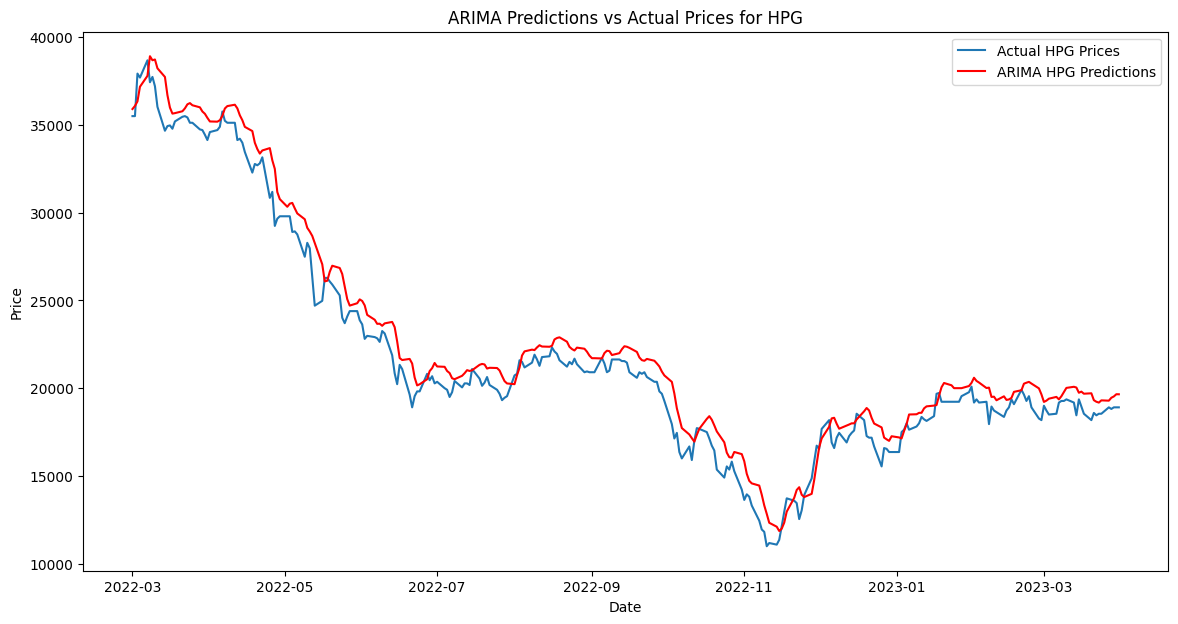

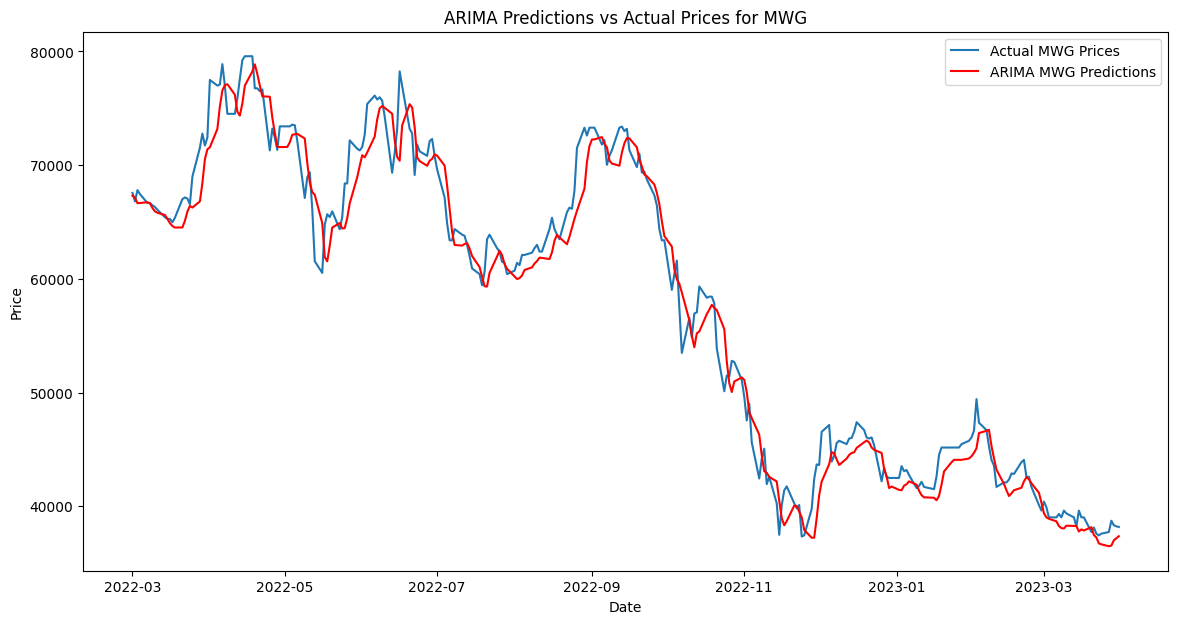

In [ ]:
# Plot ARIMA predictions for HPG
plt.figure(figsize=(14, 7))
plt.plot(hpg_data['Price']['2022-03-01':].index, hpg_data['Price']['2022-03-01':], label='Actual HPG Prices')
plt.plot(hpg_data['Price']['2022-03-01':].index, pred_hpg_arima, label='ARIMA HPG Predictions', color='red')
plt.title('ARIMA Predictions vs Actual Prices for HPG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot ARIMA predictions for MWG
plt.figure(figsize=(14, 7))
plt.plot(mwg_data['Price']['2022-03-01':].index, mwg_data['Price']['2022-03-01':], label='Actual MWG Prices')
plt.plot(mwg_data['Price']['2022-03-01':].index, pred_mwg_arima, label='ARIMA MWG Predictions', color='red')
plt.title('ARIMA Predictions vs Actual Prices for MWG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

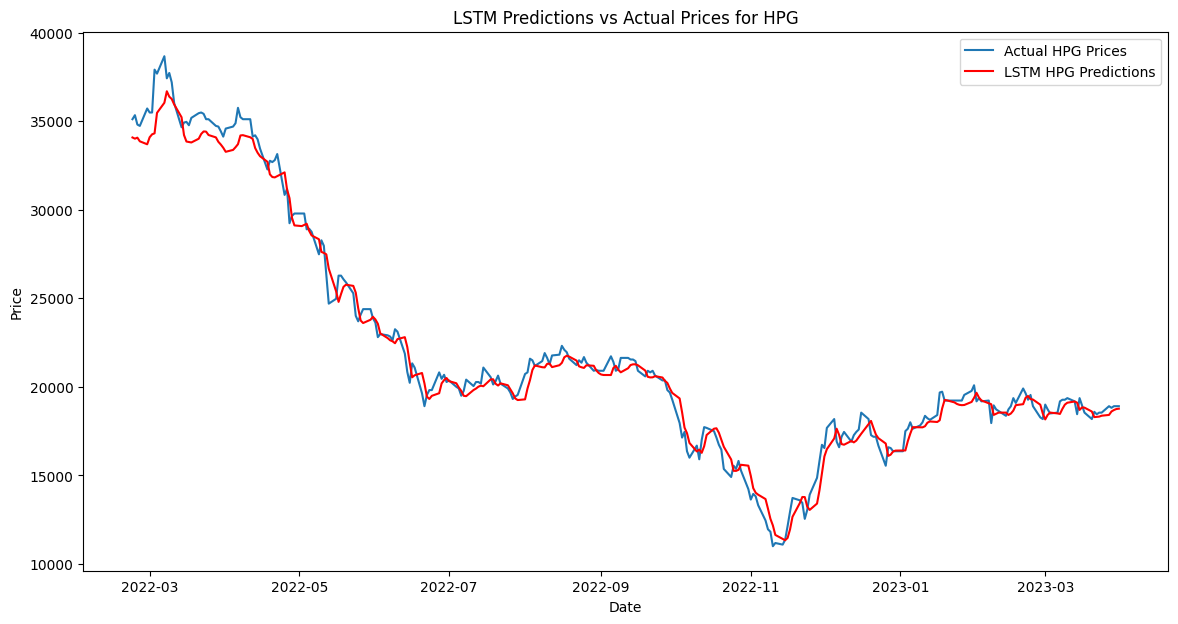

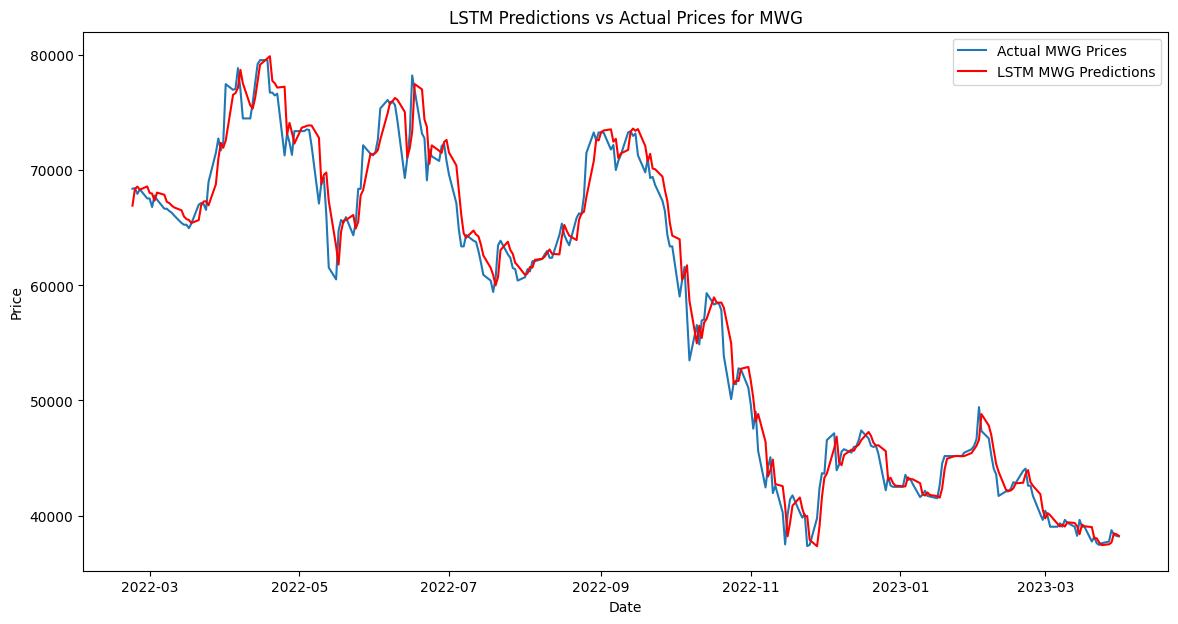

In [ ]:
# Plot LSTM predictions for HPG
plt.figure(figsize=(14, 7))
plt.plot(test_hpg_lstm.index[seq_length:], test_hpg_lstm['Price'][seq_length:], label='Actual HPG Prices')
plt.plot(test_hpg_lstm.index[seq_length:], pred_hpg_lstm, label='LSTM HPG Predictions', color='red')
plt.title('LSTM Predictions vs Actual Prices for HPG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot LSTM predictions for MWG
plt.figure(figsize=(14, 7))
plt.plot(test_mwg_lstm.index[seq_length:], test_mwg_lstm['Price'][seq_length:], label='Actual MWG Prices')
plt.plot(test_mwg_lstm.index[seq_length:], pred_mwg_lstm, label='LSTM MWG Predictions', color='red')
plt.title('LSTM Predictions vs Actual Prices for MWG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

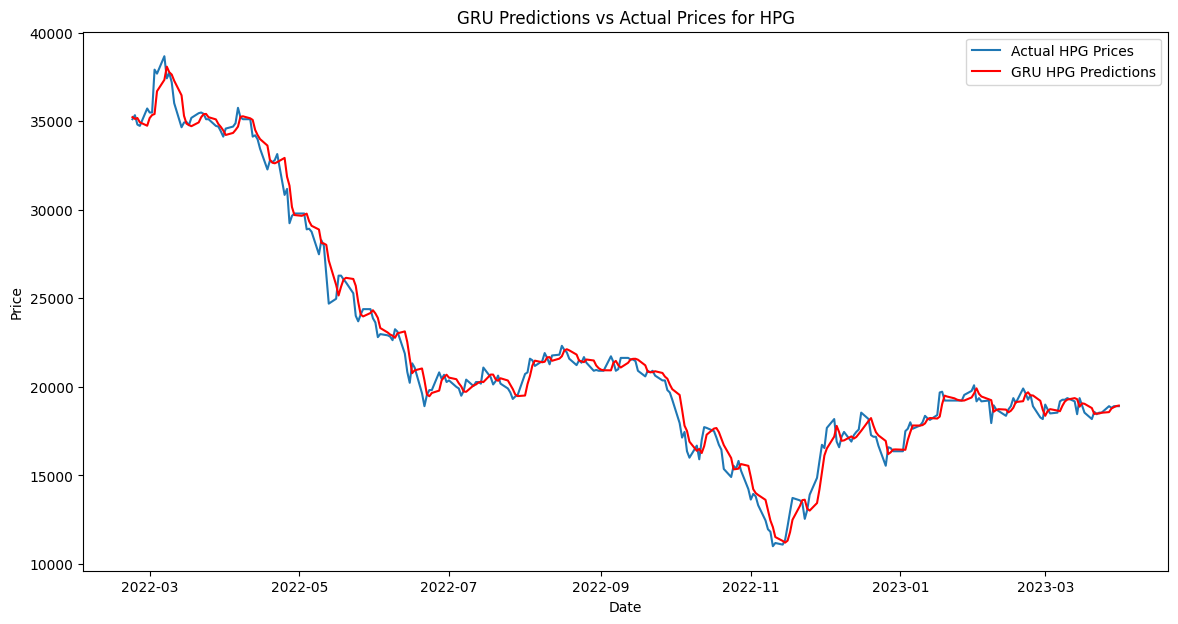

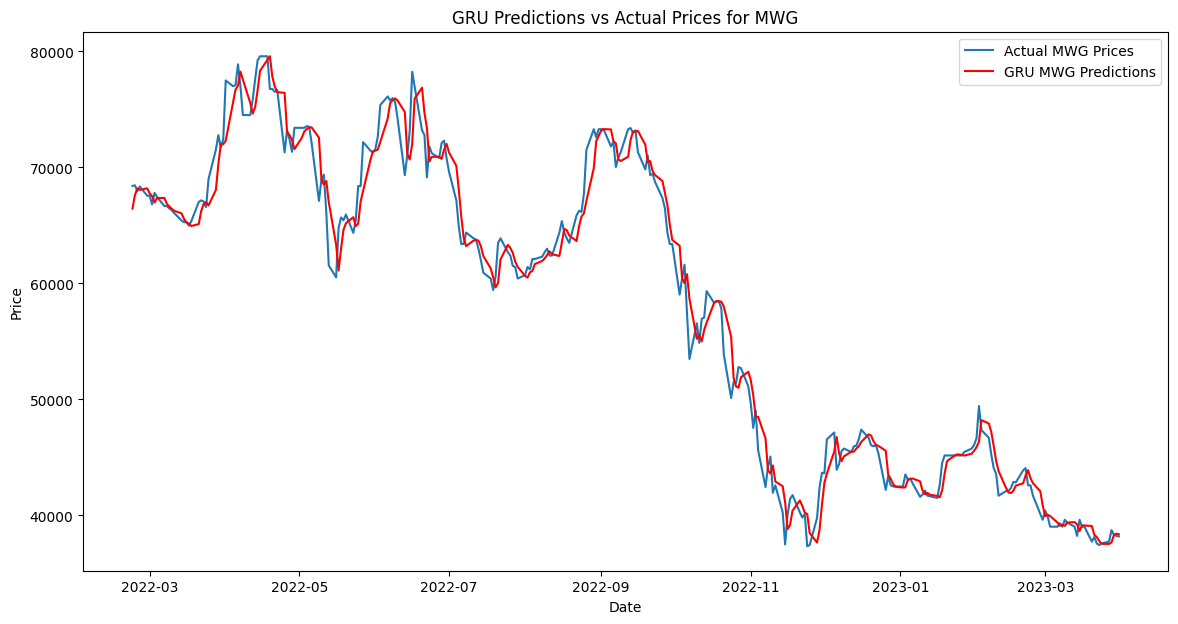

In [ ]:
# Plot GRU predictions for HPG
plt.figure(figsize=(14, 7))
plt.plot(test_hpg_lstm.index[seq_length:], test_hpg_lstm['Price'][seq_length:], label='Actual HPG Prices')
plt.plot(test_hpg_lstm.index[seq_length:], pred_hpg_gru, label='GRU HPG Predictions', color='red')
plt.title('GRU Predictions vs Actual Prices for HPG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot GRU predictions for MWG
plt.figure(figsize=(14, 7))
plt.plot(test_mwg_lstm.index[seq_length:], test_mwg_lstm['Price'][seq_length:], label='Actual MWG Prices')
plt.plot(test_mwg_lstm.index[seq_length:], pred_mwg_gru, label='GRU MWG Predictions', color='red')
plt.title('GRU Predictions vs Actual Prices for MWG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()